In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import pyBigWig


In [2]:
def make_peak_tensor(promoterome_infile,peaks_infiles):
    # Make a boolean tensor of shape (N_prom,N_pos,N_exp)
    # where N_prom is the number of promoters, N_pos is the number of base pairs in the window, and N_exp is the number of experiments
    # The tensor is True if a peak is found in the promoterome

    # get promoterome
    promoterome = pd.read_csv(promoterome_infile,sep='\t')
    CHR = promoterome.chr.unique()

    # get peaks
    peaks_table = pd.DataFrame(columns=['exp_id','chr','start','end','score'])
    for infile in peaks_infiles:
        bb = pyBigWig.open(infile)
        id = infile.split('/')[-1].split('.')[0]
        for c in CHR:
            if c in bb.chroms():
                pks = pd.DataFrame(bb.entries(c,0,bb.chroms(c)),columns=['start','end','score'])
                pks['chr'] = c
                pks['exp_id'] = id
                peaks_table = pd.concat([peaks_table,pks],axis=0)
    peaks_table = peaks_table.reset_index(drop=True)

    # overlap between peaks and promoterome
    N_prom = len(promoterome)
    N_pos = promoterome.at[0,'end'] - promoterome.at[0,'start']
    N_exp = len(peaks_infiles)
    TF_peaks = np.zeros([N_prom,N_pos,N_exp],dtype=bool) # tensor of shape (N_prom,N_pos,N_exp) X[i,j,k] is True if peak k is found in promoter i at position j
    
    exp_ids = np.array( [exp.split('/')[-1].split('.')[0] for exp in peaks_infiles] )
    x = promoterome.loc[:,['chr','start','end']].values
    for k, exp_id in enumerate(exp_ids):

        peak_idx = peaks_table[peaks_table.exp_id==exp_id].index
        y = peaks_table.loc[peak_idx,['chr','start','end']].values

        Prom_Peak_overlap = (x[:,0][:,None] == y[:,0][None,:]) & (x[:,1][:,None] <= y[:,2][None,:]) & (x[:,2][:,None] >= y[:,1][None,:])
        [idx_prom,idx_peak] = np.where(Prom_Peak_overlap)

        # Now fill in the tensor with the overlaping peaks
        for i,p in zip(idx_prom,idx_peak):
            o_start = peaks_table.loc[peak_idx[p],'start'] - promoterome.loc[i,'start']
            o_end = peaks_table.loc[peak_idx[p],'end'] - promoterome.loc[i,'start']
            j = range(max(o_start,0),min(o_end,N_pos))
            TF_peaks[i,j,k] = True

    return TF_peaks

## Plot variance & peaks per experiment and correlation & peak overlap between experiments

RuntimeError: The end coordinate must be a number!

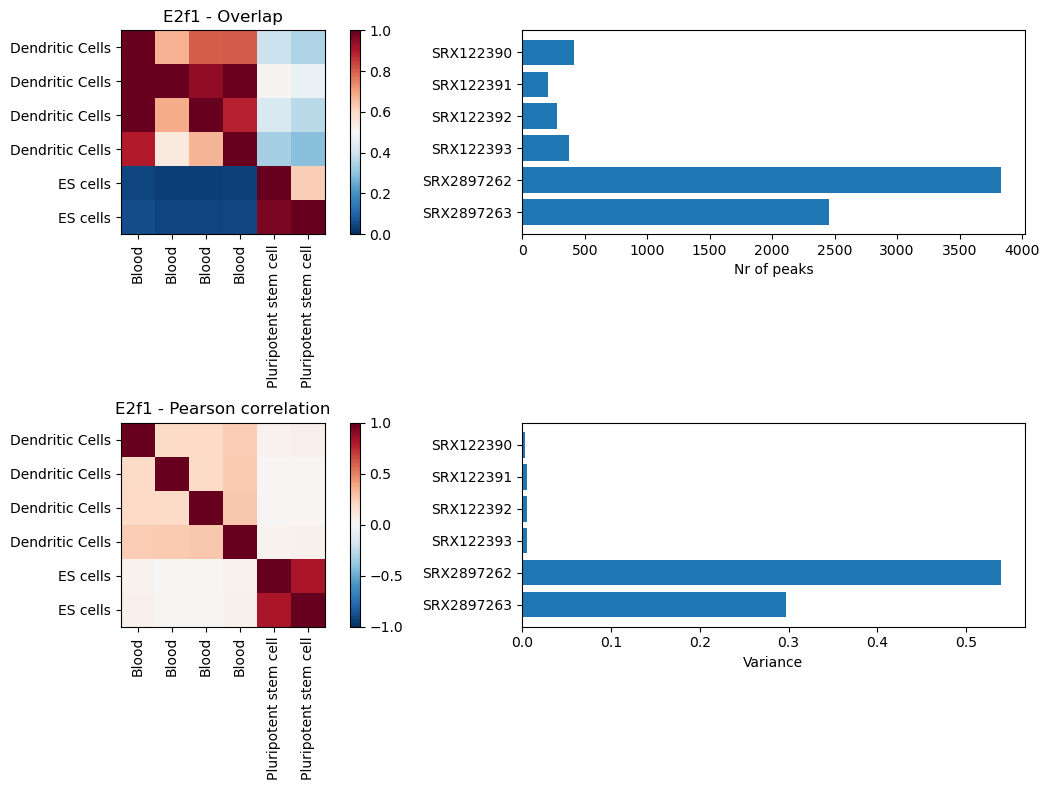

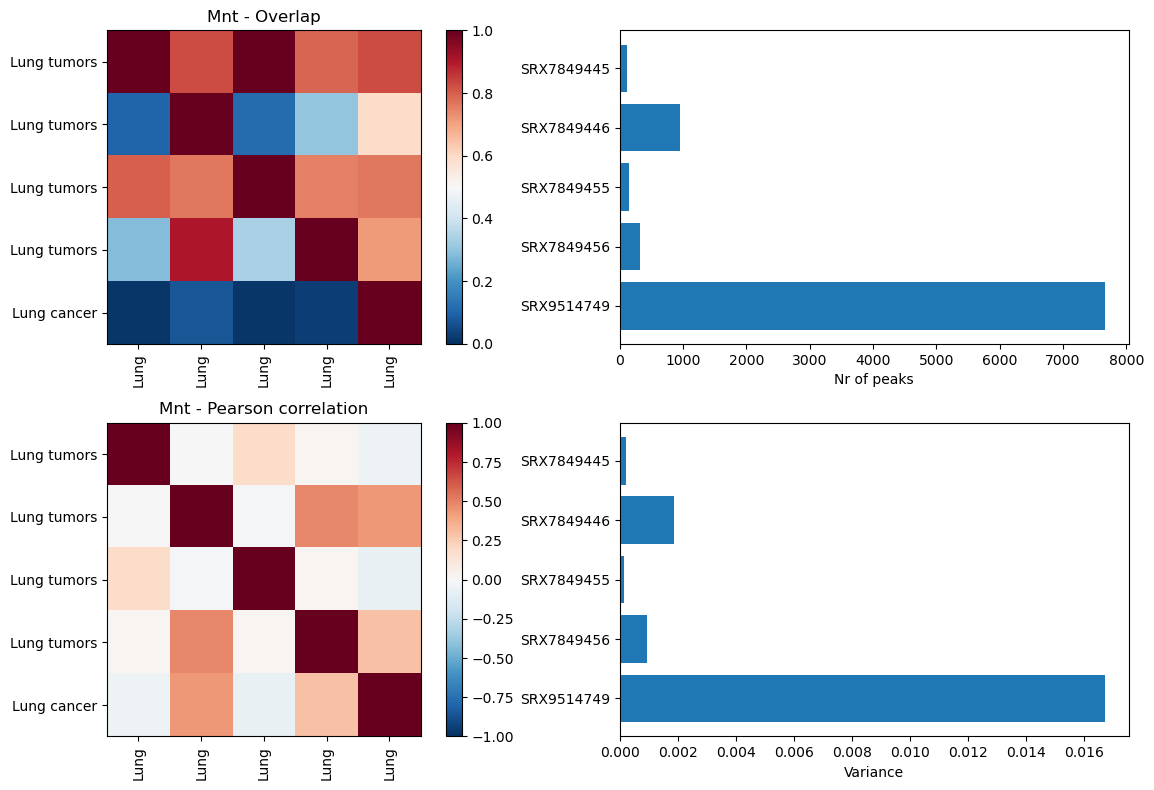

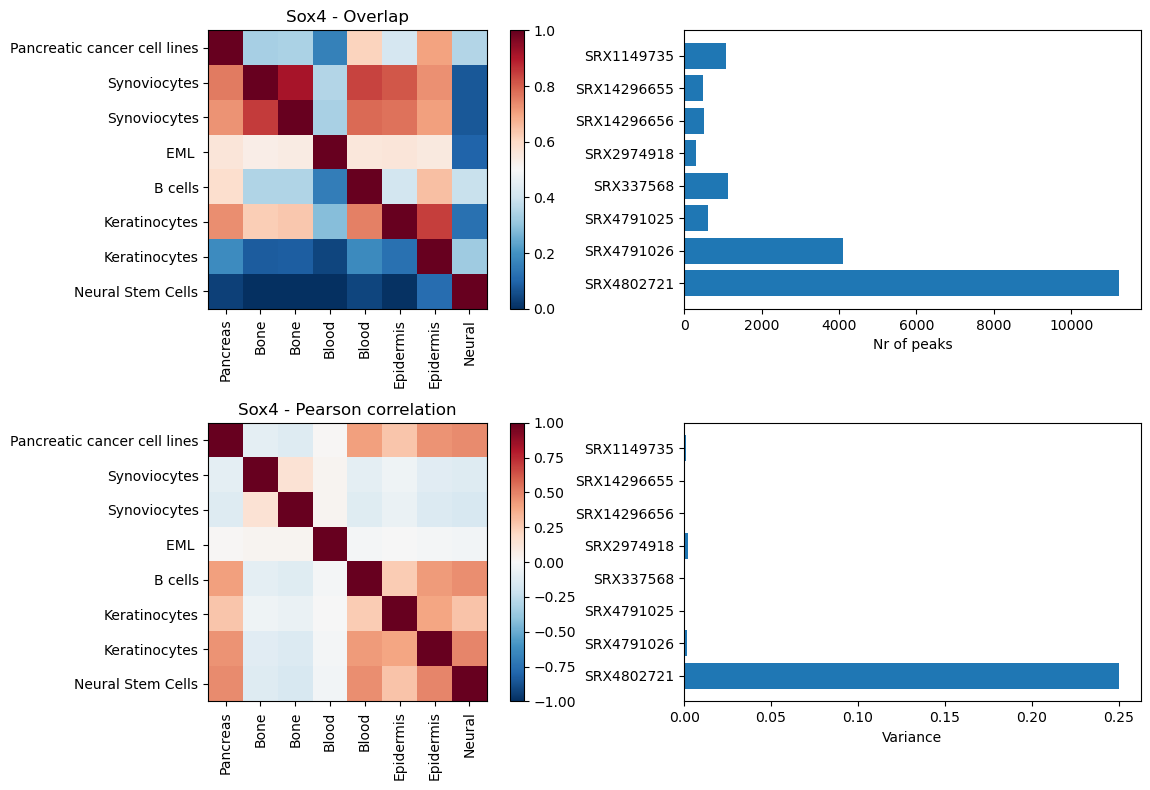

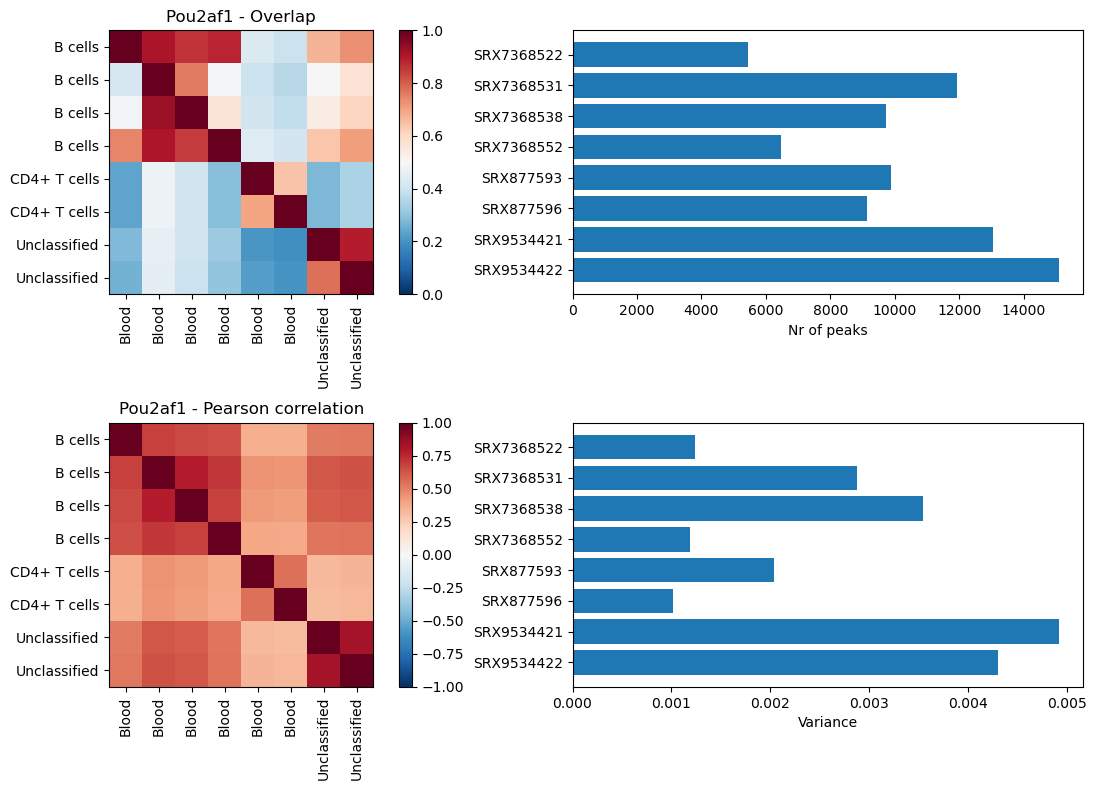

In [3]:
# parameters
genome = 'mm10'
size_factor = 100000
win = 1
CHR = [f'chr{i+1}' for i in range(19)] + ['chrX','chrY']
TFs = ['E2f1','Mnt','Sox4','Pou2af1','Bach1','E2f3','Fosb','Otx2','Pbx1','Pax7']
# get experiment table
experiments = pd.read_csv(f'../resources/experimentList_{genome}_TFs_only_QC_filtered.tab',sep = '\t',index_col = 0)
promoterome_infile = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm{win}kb_filtered.bed"
promoterome = pd.read_csv(promoterome_infile,sep='\t')

for my_tf in TFs:
    # get TF tensor
    infile = f'../results/{genome}/TF_tensors/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        my_ids = [i.decode('utf-8') for i in hf['experiment_id'][:]]
        X = hf['chip_prom_pos_exp'][:]

    my_exp = experiments.loc[my_ids,:]
    [my_celltype,celltype_idx] = np.unique(my_exp.celltype_class.values,return_inverse=True)

    # replace nans with 0s
    X[np.isnan(X)] = 0
    N_prom, N_pos, N_exp = X.shape

    X_flat = X.reshape([N_prom*N_pos,N_exp])

    # compute pearson corr.
    rho = np.corrcoef(X_flat.T)
    v = np.nanvar(X_flat,axis=0)
    m = np.nanmean(X_flat,axis=0)
    # Z score
    #X = ((X - m) / np.sqrt(v)) + m

    # average per cell type
    X_ct = np.zeros([N_prom*N_pos,len(my_celltype)])
    for i in np.unique(celltype_idx):
        X_ct[:,i] = np.mean(X_flat[:,celltype_idx==i],axis=1)

    # get peak-peak overlap
    # get peaks
    peaks_table = pd.DataFrame(columns=['exp_id','chr','start','end','score'])
    peak_infiles = [f'../resources/tracks/{genome}/{id}.05.bb' for id in my_ids]
    for infile in peak_infiles:
        bb = pyBigWig.open(infile)
        id = infile.split('/')[-1].split('.')[0]
        for c in CHR:
            if c in bb.chroms():
                pks = pd.DataFrame(bb.entries(c,0,bb.chroms(c)),columns=['start','end','score'])
                pks['chr'] = c
                pks['exp_id'] = id
                peaks_table = pd.concat([peaks_table,pks],axis=0)
    peaks_table = peaks_table.reset_index(drop=True)

    N_peaks = peaks_table['exp_id'].value_counts() # count unique ids
    N_peaks = N_peaks.loc[my_ids]
    Peaks_Overlap = np.zeros([len(my_ids),len(my_ids)])
    for i,id_i in enumerate(my_ids):
        for j,id_j in enumerate(my_ids):
            for c in CHR:
                x = peaks_table.loc[(peaks_table.exp_id==id_i)&(peaks_table.chr==c),['start','end']].values
                y = peaks_table.loc[(peaks_table.exp_id==id_j)&(peaks_table.chr==c),['start','end']].values
                idx = (x[:,0][None,:] <= y[:,1][:,None]) & (x[:,1][None,:] >= y[:,0][:,None])

                Peaks_Overlap[i,j] += idx.sum()
            Peaks_Overlap[i,j] /= N_peaks[id_i]


    # plot
    fig, axes = plt.subplots(2,2,figsize=(12,8))
    ax = axes[0,0]
    h = ax.imshow(Peaks_Overlap,cmap='RdBu_r',vmin=0,vmax=1)
    plt.colorbar(h)
    ax.set_yticks(np.arange(N_exp),my_exp['celltype'],rotation=0)
    ax.set_xticks(np.arange(N_exp),my_exp['celltype_class'],rotation=90)
    ax.set_title(f"{my_tf} - Overlap")


    ax = axes[0,1]
    ax.barh(N_peaks.index,N_peaks.values)
    ax.set_xlabel('Nr of peaks')
    ax.invert_yaxis()


    ax = axes[1,0]
    h = ax.imshow(rho, cmap='RdBu_r',vmin=-1,vmax=1)
    # shopw colot bar
    plt.colorbar(h)
    ax.set_yticks(np.arange(N_exp),my_exp['celltype'],rotation=0)
    ax.set_xticks(np.arange(N_exp),my_exp['celltype_class'],rotation=90)
    ax.set_title(f'{my_tf} - Pearson correlation')
    fig.tight_layout()


    # plot variance
    ax = axes[1,1]
    V = pd.Series(v,index=my_ids)
    ax.barh(V.index,V.values)
    ax.set_xlabel('Variance')
    ax.invert_yaxis()


    if False:
        bins = np.linspace(X_ct.min(),X_ct.max(),200)

        n = len(my_celltype)

        fig, axes = plt.subplots(n,n,figsize=(n*4,n*4))
        for i in np.unique(celltype_idx):
            for j in np.unique(celltype_idx):
                ax = axes[i,j]
                if i==j:
                    h, tmp = np.histogram(X_ct[:,i],bins=bins)
                    ax.plot((bins[:-1]+bins[1:])/2,h)
                    ax.set_xscale('log')
                    ax.set_yscale('log')
                    ax.set_title(f'{my_celltype[i]}')
                else:
                    ax.scatter(X_ct[:,i],X_ct[:,j],s=1,alpha=.5)
                    #ax.set_xscale('log')
                    #ax.set_yscale('log')
                    ax.set_title(f'{my_celltype[i]} vs {my_celltype[j]}')

## Compare variance in and out of peaks between experiments

In [3]:
# Compare distributions in and out peaks
# parameters
genome = 'mm10'
size_factor = 100000
win = 1
CHR = [f'chr{i+1}' for i in range(19)] + ['chrX','chrY']
TFs = ['E2f1','Mnt','Sox4','Pou2af1','Bach1','E2f3','Fosb','Otx2','Pbx1','Pax7']
# get experiment table
experiments = pd.read_csv(f'../resources/experimentList_{genome}_TFs_only_QC_filtered.tab',sep = '\t',index_col = 0)
promoterome_infile = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm{win}kb_filtered.bed"

v_in = {}
v_out = {}
h_in = {}
h_out = {}

for my_tf in TFs[:1]:
    print(my_tf)
    
    # get TF tensor
    infile = f'../results/{genome}/TF_tensors/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        my_ids = [i.decode('utf-8') for i in hf['experiment_id'][:]]
        X = hf['chip_prom_pos_exp'][:]

    my_exp = experiments.loc[my_ids,:]
    [my_celltype,celltype_idx] = np.unique(my_exp.celltype_class.values,return_inverse=True)

    # replace nans with 0s
    X[np.isnan(X)] = 0
    N_prom, N_pos, N_exp = X.shape
    X_flat = X.reshape([N_prom*N_pos,N_exp])
        
    # get peaks tensor
    peak_infiles = [f'../resources/tracks/{genome}/{id}.05.bb' for id in my_ids]
    Peaks = make_peak_tensor(promoterome_infile,peak_infiles)

    # get binned tensor
    bin_size = int(Peaks.shape[1]/N_pos)

    Peaks_binned = Peaks.reshape([N_prom,N_pos,bin_size,N_exp]).any(axis=2)

    Peaks_binned_flat = Peaks_binned.reshape([N_prom*N_pos,N_exp])

    N_bin = 100
    for i in range(N_exp):
        v_in[my_ids[i]] = np.nanvar(X_flat[Peaks_binned_flat[:,i],i])
        v_out[my_ids[i]] = np.nanvar(X_flat[~Peaks_binned_flat[:,i],i])
        h_in[my_ids[i]] = np.histogram(X_flat[Peaks_binned_flat[:,i],i],bins=N_bin)
        h_out[my_ids[i]] = np.histogram(X_flat[~Peaks_binned_flat[:,i],i],bins=N_bin)


E2f1


In [17]:
n_peaks_per_prom = np.any(Peaks,axis=1).sum(axis=1)
idx = np.argsort( n_peaks_per_prom )
promoterome = pd.read_csv(promoterome_infile,sep='\t')
promoterome['n_peaks'] = n_peaks_per_prom
promoterome.loc[idx,:]

,chr,start,end,strand,black_listed,gene,id,n_peaks
28806,chrY,10533428,10535428,-,.,Gm20737,chrY_-_10534428_10534428,0
16198,chr3,142559381,142561381,+,.,Gbp3,chr3_+_142560351_142560411,0
16197,chr3,142559126,142561126,+,.,Gbp3,chr3_+_142560108_142560145,0
16196,chr3,142559078,142561078,+,.,Gbp3,chr3_+_142560052_142560105,0
16195,chr3,142529357,142531357,+,.,Gbp7,chr3_+_142530329_142530386,0
...,...,...,...,...,...,...,...,...
12163,chr19,3766993,3768993,+,.,Suv420h1,chr19_+_3767953_3768033,3
4743,chr11,83648357,83650357,-,.,Ccl3,chr11_-_83649349_83649365,3
6712,chr13,22040357,22042357,-,.,Hist1h4i,chr13_-_22041352_22041363,3
12164,chr19,3767172,3769172,+,.,Suv420h1,chr19_+_3768112_3768233,3


In [16]:
n_peaks_per_prom

array([0, 0, 0, ..., 3, 3, 4])

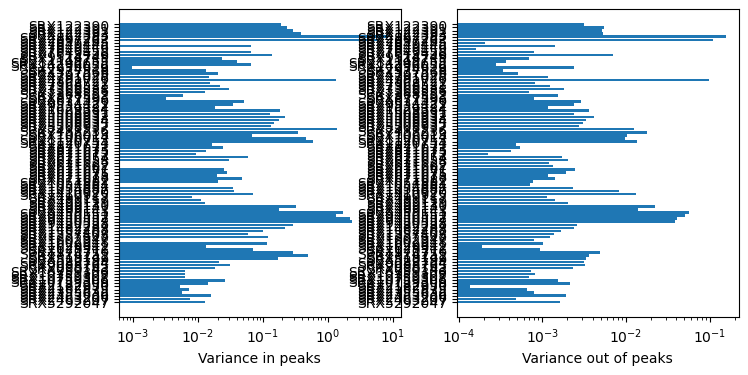

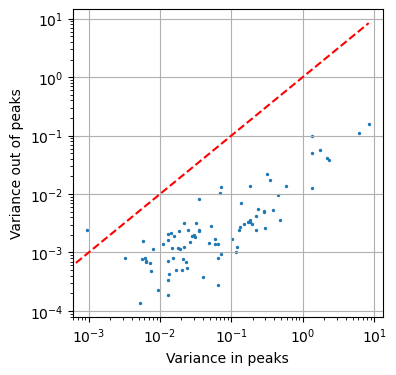

In [19]:
v_in = pd.Series(v_in)
v_out = pd.Series(v_out)

fig, axes = plt.subplots(1,2,figsize=(8,4))
ax = axes[0]
ax.barh(v_in.index,v_in.values)
ax.set_xlabel('Variance in peaks')
ax.invert_yaxis()
ax.set_xscale('log')

ax = axes[1]
ax.barh(v_out.index,v_out.values)
ax.set_xlabel('Variance out of peaks')
ax.invert_yaxis()
ax.set_xscale('log')

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot([v_in.min(),v_in.max()],[v_in.min(),v_in.max()],'r--')
ax.scatter(v_in.values,v_out.values,s=2)
ax.set_xlabel('Variance in peaks')
ax.set_ylabel('Variance out of peaks')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
if False:
    n = int(np.ceil(np.sqrt(len(h_in))))
    fig, axes = plt.subplots(n,n,figsize=(4*n,4*n))
    for i,id in enumerate(h_in):
        ax = axes.flatten()[i]
        ax.plot((h_in[id][1][:-1]+h_in[id][1][1:])/2,h_in[id][0],'.',label='in peaks')
        ax.plot((h_out[id][1][:-1]+h_out[id][1][1:])/2,h_out[id][0],'.',label='out of peaks')
        ax.set_yscale('log')
        ax.set_title(id)




SRX122390     0.192456
SRX122391     0.232914
SRX122392     0.287436
SRX122393     0.388711
SRX2897262    8.416993
                ...   
SRX2355635    0.007279
SRX2355636    0.005657
SRX2463206    0.015728
SRX2463207    0.007578
SRX5292047    0.012915
Length: 91, dtype: float64

## Quantile norm of TF ChIP signal

In [32]:
# Compare distributions in and out peaks
# parameters
genome = 'mm10'
size_factor = 100000
win = 1
CHR = [f'chr{i+1}' for i in range(19)] + ['chrX','chrY']
TFs = ['E2f1','Mnt','Sox4','Pou2af1','Bach1','E2f3','Fosb','Otx2','Pbx1','Pax7']
# get experiment table
experiments = pd.read_csv(f'../resources/experimentList_{genome}_TFs_only_QC_filtered.tab',sep = '\t',index_col = 0)
promoterome_infile = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm{win}kb_filtered.bed"

X = np.zeros([0,0,0])
for my_tf in TFs:
    print(my_tf)
    
    # get TF tensor
    infile = f'../results/{genome}/TF_tensors/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        my_ids = [i.decode('utf-8') for i in hf['experiment_id'][:]]
        x = hf['chip_prom_pos_exp'][:]
    
    if X.size == 0:
        X = x
    else:
        X = np.concatenate([X,x],axis=2)

E2f1
Mnt
Sox4
Pou2af1
Bach1
E2f3
Fosb
Otx2
Pbx1
Pax7


In [50]:
X = X.reshape([X.shape[0]*X.shape[1],X.shape[2]])

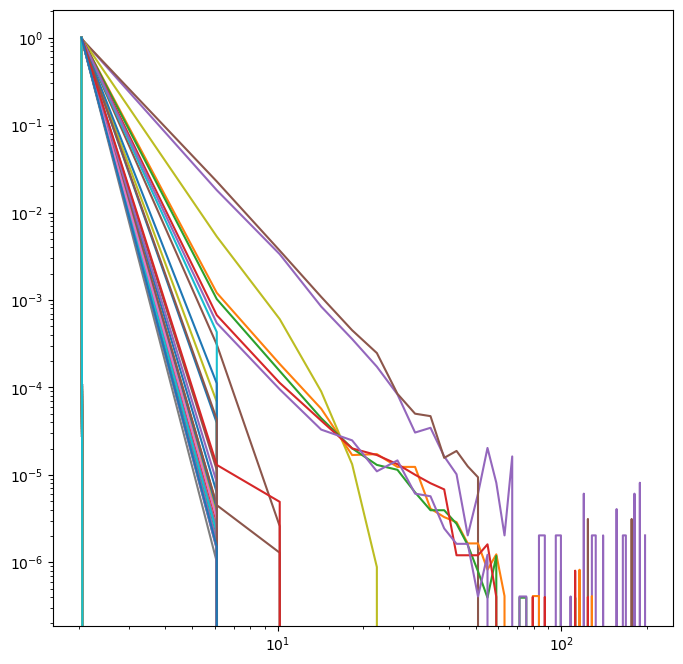

In [104]:

bins = np.logspace(-1,np.log10(X[~np.isnan(X)].max()),50)
#bins = np.linspace(0,X[~np.isnan(X)].max(),50)
dx = np.diff(bins)
H = np.zeros([len(bins)-1,X.shape[1]])
for i in range(X.shape[1]):
    idx = ~np.isnan(X[:,i])
    H[:,i], tmp = np.histogram(X[idx,i],bins=bins,density=False)

# normalize
#H = H / dx[:,None] 
H = H / H.sum(axis=0)

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot((bins[:-1]+bins[1:])/2,H)
ax.set_xscale('log')
ax.set_yscale('log')



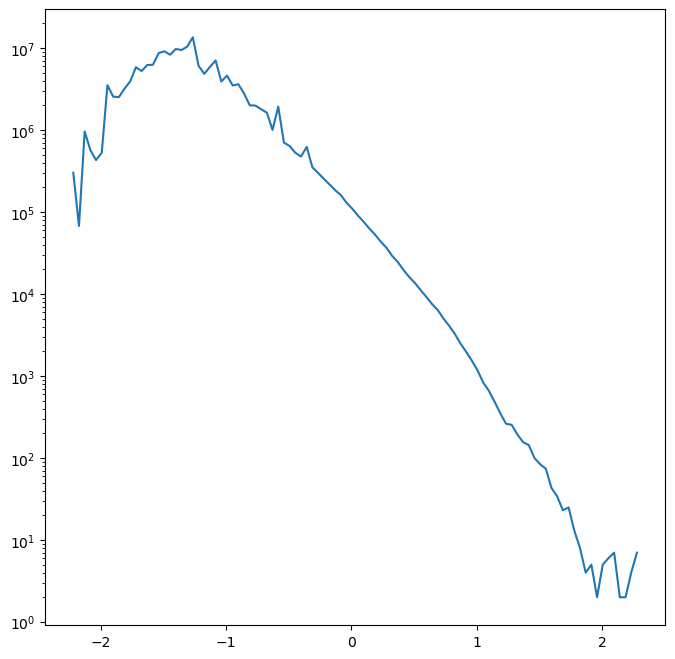

In [111]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
h,x = np.histogram(np.log10( X[~np.isnan(X)] ),bins=100)

ax.plot((x[:-1]+x[1:])/2,h)
ax.set_yscale('log')

In [74]:
tmp

array([5.75532997e-03, 1.00666887e+00, 2.00758241e+00, 3.00849595e+00,
       4.00940949e+00, 5.01032303e+00, 6.01123658e+00, 7.01215012e+00,
       8.01306366e+00, 9.01397720e+00, 1.00148907e+01, 1.10158043e+01,
       1.20167178e+01, 1.30176314e+01, 1.40185449e+01, 1.50194584e+01,
       1.60203720e+01, 1.70212855e+01, 1.80221991e+01, 1.90231126e+01,
       2.00240261e+01, 2.10249397e+01, 2.20258532e+01, 2.30267668e+01,
       2.40276803e+01, 2.50285939e+01, 2.60295074e+01, 2.70304209e+01,
       2.80313345e+01, 2.90322480e+01, 3.00331616e+01, 3.10340751e+01,
       3.20349886e+01, 3.30359022e+01, 3.40368157e+01, 3.50377293e+01,
       3.60386428e+01, 3.70395563e+01, 3.80404699e+01, 3.90413834e+01,
       4.00422970e+01, 4.10432105e+01, 4.20441240e+01, 4.30450376e+01,
       4.40459511e+01, 4.50468647e+01, 4.60477782e+01, 4.70486918e+01,
       4.80496053e+01, 4.90505188e+01, 5.00514324e+01, 5.10523459e+01,
       5.20532595e+01, 5.30541730e+01, 5.40550865e+01, 5.50560001e+01,
      